## DSTA

### Chapter V - Financial networks.

#### This __demonstration (no exercise)__ notebook is taken from the notebook for Ch. 5 of Caldarelli-Cheesa's textbook (CC).

Please see the [class repository](https://www.dcs.bbk.ac.uk/~ale/dsta/) for the datasets.

For local usage, it is recommended to install yfinance from within Anaconda, e.g.

```bash
C:\WINDOWS\system32>conda install -c ranaroussi yfinance
```
or from the Navigator tool, e.g. by subscribing to the "ranaroussi" channel.
Without Anaconda, you may install the package directly:

```bash
C:\WINDOWS\system32>pip install yfinance
```

In any case these commands are repeated below, please comment out as needed.

#### Changelog

- June 2024 version by A. Matuozzo updates the code to the current availability of modules.
Notice: recent Networkx versiona are deprecating Graphviz.pydot

- March 2023 version by P. Lagias runs on a reduced dataset of tickers to avoid issues with delisted/defunct stocks.



In [ ]:
# !pip install graphviz


In [ ]:
# !pip install yfinance

#### Discontinued:

the original yahooFinacials module is no longer used as it is falling out of maintenance.
It used to be installed with `!pip install yahoofinancials`

Now, let us make sure that we have the `seaborn` module for visualisation

Notice: this notebook can be run without it, `matplotlib` suffices.

In [ ]:
# !pip install seaborn

In [1]:
import sys
import time
import math

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns


import networkx as nx

from networkx.drawing.nx_pydot import graphviz_layout

from collections import Counter

import yfinance as yf

#from yahoofinancials import YahooFinancials

#from yahoofinancials.etl import ManagedException


### Connecting to the Yahoo! Finance service

What with Apple Inc. on May 19th 2014?

In [ ]:
# Download data for 1 day as an example
data = yf.download("AAPL", start = "2014-05-19", end = "2014-05-20")

print(data)

<ipython-input-7-995268900>:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start = "2014-05-19", end = "2014-05-20")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2014-05-19  19.010418  19.096573  18.782137  18.798488  317755200


In [ ]:
#this data is structured as a pandas dataframe to benefits from its built in methods
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-05-19,19.010418,19.096573,18.782137,18.798488,317755200


In [ ]:
#setting the Date as index gives access to pandas functions to sample time series data
data.index

DatetimeIndex(['2014-05-19'], dtype='datetime64[ns]', name='Date', freq=None)

#### Compute and plot transaction volumes

How was Microsoft traded in 2019?

In [ ]:
# Now download the data for the entire 2019 year.
d = yf.download("MSFT", start = "2019-01-01", end = "2019-12-31")

d['Transaction_Volume'] = d['Volume'] * d['Close']

print(d)

<ipython-input-13-271148352>:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d = yf.download("MSFT", start = "2019-01-01", end = "2019-12-31")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume  \
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT   
Date                                                                   
2019-01-02   94.945503   95.537032   92.898616   93.471369  35329300   
2019-01-03   91.452667   94.072308   91.264875   93.987800  42579100   
2019-01-04   95.706062   96.250649   92.889245   93.631008  44060600   
2019-01-07   95.828125   96.964240   94.814076   95.433772  35656100   
2019-01-08   96.522926   97.621483   95.499479   96.748270  31514400   
...                ...         ...         ...         ...       ...   
2019-12-23  149.983765  150.660260  149.850370  150.660260  17718200   
2019-12-24  149.955139  150.269572  149.707396  150.050413   8989200   
2019-12-26  151.184280  151.241447  149.974192  150.126647  14520600   
2019-12-27  151.460678  152.022840  150.755584  151.927552  18412800   
2019-12-30  150.155212  151.517755  149.335785  151.489172  1634

In [ ]:
# Downloaded data are saved as a dataframe
type(d)

pandas.core.frame.DataFrame

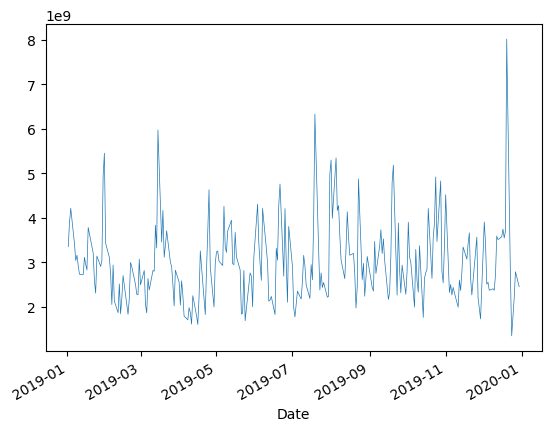

In [ ]:
# Use seaborn style defaults and set the default figure size
sns.set_style(rc = {'figure.figsize': (12, 6)})

d['Transaction_Volume'].plot(linewidth = 0.5);

#### The NYSE tickers

From the relative [nasdaq.com](http://www.nasdaq.com/screening/company-list.aspx) page we download all the information related to the market capitalization, sector and industry...

Discontinued: the top-cap companies have been downloaded in the `data` section, use `!head companylist.csv` to visualise, OR SIMPLY USE THE Pandas version below.

### Get Stock Labels, Sector and Industries

In [2]:
DATAFILE = "./sample_data/list_stocks_50B_6_may_2016.txt"

In [8]:
# Get stock data from the text file
f = open(DATAFILE, 'r')

list_stocks = []

while True:
    next_line = f.readline()
    if not next_line: break
    # print(next_line.split('\t'))
    list_stocks.append(tuple(next_line.split('\t')[:-1]))

f.close()

# a huge dump of all stocks, uncomment only if needed
for stock in list_stocks:
    print(stock)


('MMM', '3M Company', 'Health Care', 'Medical/Dental Instruments')
('ABT', 'Abbott Laboratories', 'Health Care', 'Major Pharmaceuticals')
('ABBV', 'AbbVie Inc.', 'Health Care', 'Major Pharmaceuticals')
('ACN', 'Accenture plc.', 'Miscellaneous', 'Business Services')
('AEB', 'Aegon NV', 'Finance', 'Life Insurance')
('AED', 'Aegon NV', 'Finance', 'Life Insurance')
('AEK', 'Aegon NV', 'Finance', 'Life Insurance')
('BABA', 'Alibaba Group Holding Limited', 'Miscellaneous', 'Business Services')
('MO', 'Altria Group', 'Consumer Non-Durables', 'Farming/Seeds/Milling')
('ABEV', 'Ambev S.A.', 'Consumer Non-Durables', 'Beverages (Production/Distribution)')
('AXP', 'American Express Company', 'Finance', 'Finance: Consumer Services')
('AIG', 'American International Grou', 'n/a', 'Finance')
('BUD', 'Anheuser-Busch Inbev SA', 'Consumer Non-Durables', 'Beverages (Production/Distribution)')
('AZN', 'Astrazeneca PLC', 'Health Care', 'Major Pharmaceuticals')
('T', 'AT&T Inc.', 'Public Utilities', 'Telecom

In [6]:
# Alternatively, you could use an easier to read DataFrame structure
stocks = pd.read_csv(DATAFILE, sep = '\t', names = ['Ticker', 'Name', 'Sector', 'Industry', 'Ukn'])

In [7]:
stocks.head()

,Ticker,Name,Sector,Industry,Ukn
0,MMM,3M Company,Health Care,Medical/Dental Instruments,NaN
1,ABT,Abbott Laboratories,Health Care,Major Pharmaceuticals,NaN
2,ABBV,AbbVie Inc.,Health Care,Major Pharmaceuticals,NaN
3,ACN,Accenture plc.,Miscellaneous,Business Services,NaN
4,AEB,Aegon NV,Finance,Life Insurance,NaN


In [ ]:
# This code must stay commented as yahoo financials has some api issues.
# We have used the file with the required data above.

# # get values
# # May 6th 2016
# # greater than 50B$
# cap_threshold = 50_000_000_000
# hfile = open("companylist.csv", 'r')

# list_stocks = []
# nextline = hfile.readline()

# while True:
#     nextline = hfile.readline()
#     if not nextline:
#         break

#     line = nextline.split(',')
#     sym = line[0][1:-1]

#     # Skip entries with "^" in stock name
#     if sym.find("^") != -1:
#         continue

#     share = YahooFinancials(sym) # this cause an issue
#     y_market_cap = None

#     try:
#         y_market_cap = share.get_market_cap()
#     except:
#         y_market_cap = None
#         print(f"No link for {sym}")
#     # y_market_cap1=y_m

#     if not y_market_cap:
#         print(f"No market cap found for {sym}")
#         continue

#     # We will exclude stocks with char ’^’ that will
#     # give errors in the query process
#     if y_market_cap > cap_threshold:
#         print(sym, y_market_cap, line)
#         stock_data = (line[0][1:-1], line[1][1:-1], line[5][1:-1], line[6][1:-1])
#         list_stocks.append(stock_data)
#     time.sleep(1)

# hfile.close()
# print(list_stocks[0])

#### Generate dictionaries for companies, sectors and colors

In [12]:
dict_sectors = {}

for s in list_stocks:
    # print(s)
    dict_sectors[s[0]] = s[2]

list_ranking = []

for s in set(dict_sectors.values()):
    count = 0

    for key in dict_sectors:
        if s in dict_sectors[key]:
            count += 1

    list_ranking.append((count,s))

list_ranking.sort(reverse = True)

# list_colors=['red','green','blue','black''cyan','magenta','yellow']
list_colors = ['0.0', '0.2', '0.4', '0.6', '0.7', '0.8', '0.9']

# 'white' is an extra color for 'n/a' and 'other' sectors
dict_colors = {}

# association color and more represented sectors
for s in list_ranking:
    if s[1] == 'n/a':
        dict_colors[s[1]] = 'white'
        continue

    if list_colors == []:
        dict_colors[s[1]] = 'white'
        continue

    dict_colors[s[1]] = list_colors.pop(0)

print(list_ranking)

[(21, 'n/a'), (21, 'Finance'), (13, 'Health Care'), (13, 'Energy'), (9, 'Public Utilities'), (9, 'Capital Goods'), (8, 'Consumer Non-Durables'), (7, 'Basic Industries'), (6, 'Consumer Services'), (5, 'Technology'), (4, 'Miscellaneous'), (3, '1999'), (1, 'Transportation')]


In [10]:
# Here you could refactor the sector dictionary like this:
sd = {k:v for k,v in zip(stocks.Ticker, stocks.Sector)}

sd

{'MMM': 'Health Care',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Miscellaneous',
 'AEB': 'Finance',
 'AED': 'Finance',
 'AEK': 'Finance',
 'BABA': 'Miscellaneous',
 'MO': 'Consumer Non-Durables',
 'ABEV': 'Consumer Non-Durables',
 'AXP': 'Finance',
 'AIG': nan,
 'BUD': 'Consumer Non-Durables',
 'AZN': 'Health Care',
 'T': 'Public Utilities',
 'SAN': nan,
 'BAC': 'Finance',
 'BNS': 'Finance',
 'BCS': 'Finance',
 'BHP': 'Basic Industries',
 'BBL': 'Energy',
 'BLK': '1999',
 'BA': 'Capital Goods',
 'BP': 'Energy',
 'BMY': 'Health Care',
 'BT': 'Public Utilities',
 'CX': 'Capital Goods',
 'CVX': 'Energy',
 'LFC': 'Finance',
 'CHL': 'Public Utilities',
 'SNP': 'Energy',
 'C': 'Finance',
 'CEO': 'Energy',
 'KO': 'Consumer Non-Durables',
 'CL': 'Consumer Non-Durables',
 'CCV': 'Consumer Services',
 'COP': 'Energy',
 'CVS': 'Health Care',
 'DHR': 'Capital Goods',
 'DEO': 'Consumer Non-Durables',
 'DOW': 'Basic Industries',
 'DUK': 'Public Utilities',
 'DD': 'Basic Industries',
 '

### Retrieving historical data

Ticker by ticker, we download the historical data from Yahoo! Finance.
The cell below will take time to run.

Example: `AEK` is not listed anymore, while `BABA` is in the NSYE top-cap only since Sep. 2014.


In [13]:
dict_comp = {}

for s in list_stocks:
    print(s[0])

    #stock = yf.Ticker(s[0])
    #diz_comp[s[0]]=stock.history("1mo")
    dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")

# create dictionaries of time series for each company

MMM


<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ABT


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ABBV


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ACN


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


AEB


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


AED


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


AEK


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AEK']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BABA


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BABA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31) (Yahoo error = "Data doesn\'t exist for startDate = 1367380800, endDate = 1401508800")')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


MO


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ABEV


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


AXP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


AIG


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BUD


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


AZN


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


T


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


SAN


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BAC


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BNS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BCS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BHP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BBL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BBL']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BLK


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BA


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BMY


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


BT


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BT']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CX


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CVX


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


LFC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LFC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CHL


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CHL']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


SNP


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SNP']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


C


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CEO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CEO']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


KO


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CL


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CCV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CCV
COP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


CVS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DHR


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DEO


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DOW


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31) (Yahoo error = "Data doesn\'t exist for startDate = 1367380800, endDate = 1401508800")')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DUK


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DD


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


LLY


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


EMC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31) (Yahoo error = "Data doesn\'t exist for startDate = 1367380800, endDate = 1401508800")')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


E


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


EPD


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


XOM


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


F


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


GE


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


GSK


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


GS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TV


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


HDB


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


HD


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


HON


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


HSBC


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HSEA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


HSEA
HSEB


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


INZ


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INZ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ISF


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ISF']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


IBM


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ITUB


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


JPM


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


JNJ


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


LYG


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


LMT


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


LOW


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


MA


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


MCD


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


MDT


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


MRK


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MTU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


MTU
MS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


NGG


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


NEE


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


NKE


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NTT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


NTT
NVS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


NVO


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DCM


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DCM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31) (Yahoo error = "Data doesn\'t exist for startDate = 1367380800, endDate = 1401508800")')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


OXY


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


ORCL


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


PEP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


PTR
PFE


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


PM


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


PG


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['RAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


RAI
RIO


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


RY


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


SNY


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


SAP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


SLB


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


SPG


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


STO


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['STO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TSM


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TEF


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TMO


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TWC


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2013-05-01 -> 2014-05-31)')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TWX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWX']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TJX


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TD


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TOT


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TOT']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


TM


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


USB


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UBS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UN


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['UN']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UL


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UNP


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UPS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UTX


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['UTX']: YFTzMissingError('possibly delisted; no timezone found')
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


UNH


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


VZ


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")
[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


VZA
V


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


WMT


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


DIS


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


WFC


[*********************100%***********************]  1 of 1 completed
<ipython-input-13-578904359>:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dict_comp[s[0]] = yf.download((s[0]), start = "2013-05-01", end = "2014-05-31")


WBK


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WBK']: YFTzMissingError('possibly delisted; no timezone found')


In [14]:
# this is a dict of DataFrames: let's look inside, for example the well-known 3M company

dict_comp['MMM'][0:5]

Price,Close,High,Low,Open,Volume
Ticker,MMM,MMM,MMM,MMM,MMM
Date,,,,,
2013-05-01,59.367672,59.691339,59.293853,59.498274,3897644
2013-05-02,60.213734,60.406798,59.572074,59.645894,3730922
2013-05-03,61.230183,61.667420,60.673700,60.736162,3603668
2013-05-06,61.235859,61.321036,61.014406,61.116614,2600582
2013-05-07,61.332386,61.536808,61.071181,61.105249,2673299


In [15]:
dict_historical = {} # this is a dict of tickers: Pd.Series of Closing Prices (how many days have the companies been traded?)

for k in list(dict_comp.keys()):
    tmp = dict_comp[k]
    dict_historical[k] = tmp['Close']
    """
    for e in diz_comp[k]:
        print(e)
        # string indices must be integers
        #diz_historical[k][e['Date']]=e['Close']
        #print(e)
        #diz_historical[k][e[0]]=e[4]
    """

for k in list(dict_historical.keys()):
    print(k, len(dict_historical[k]))

MMM 273
ABT 273
ABBV 273
ACN 273
AEB 273
AED 273
AEK 0
BABA 0
MO 273
ABEV 273
AXP 273
AIG 273
BUD 273
AZN 273
T 273
SAN 273
BAC 273
BNS 273
BCS 273
BHP 273
BBL 0
BLK 273
BA 273
BP 273
BMY 273
BT 0
CX 273
CVX 273
LFC 0
CHL 0
SNP 0
C 273
CEO 0
KO 273
CL 273
CCV 0
COP 273
CVS 273
DHR 273
DEO 273
DOW 0
DUK 273
DD 273
LLY 273
EMC 0
E 273
EPD 273
XOM 273
F 273
GE 273
GSK 273
GS 273
TV 273
HDB 273
HD 273
HON 273
HSBC 273
HSEA 0
HSEB 140
INZ 0
ISF 0
IBM 273
ITUB 273
JPM 273
JNJ 273
LYG 273
LMT 273
LOW 273
MA 273
MCD 273
MDT 273
MRK 273
MTU 0
MS 273
NGG 273
NEE 273
NKE 273
NTT 0
NVS 273
NVO 273
DCM 0
OXY 273
ORCL 273
PEP 273
PTR 0
PFE 273
PM 273
PG 273
RAI 0
RIO 273
RY 273
SNY 273
SAP 273
SLB 273
SPG 273
STO 0
TSM 273
TEF 273
TMO 273
TWC 0
TWX 0
TJX 273
TD 273
TOT 0
TM 273
USB 273
UBS 273
UN 0
UL 273
UNP 273
UPS 273
UTX 0
UNH 273
VZ 273
VZA 66
V 273
WMT 273
DIS 273
WFC 273
WBK 0


In [16]:
dict_historical['MMM']

Ticker,MMM
Date,
2013-05-01,59.367672
2013-05-02,60.213734
2013-05-03,61.230183
2013-05-06,61.235859
2013-05-07,61.332386
...,...
2014-05-23,82.483498
2014-05-27,82.658821
2014-05-28,82.652954


###  Calculation of the logreturns

Let's visualise a company

In [19]:
REF_COMPANY = 'MMM'

In [33]:
# Get sorted list of trading dates
d = sorted(list(dict_historical[REF_COMPANY].index))

print(f"Total dates for {REF_COMPANY}: {len(d)}")

dict_returns = {}

for c in dict_historical:
    # Skip if the company doesn't have full data
    if len(dict_historical[c].index) < len(d):
        continue

    dict_returns[c] = {}
    for i in range(1, len(d)):
        # Get closing prices and compute log returns safely
        return_t = math.log(float(dict_historical[c].loc[d[i]].iloc[0]))
        return_t_1 = math.log(float(dict_historical[c].loc[d[i-1]].iloc[0]))
        dict_returns[c][d[i]] = return_t - return_t_1

# Print the log returns for the reference company
print(dict_returns[REF_COMPANY])

Total dates for MMM: 273
{Timestamp('2013-05-02 00:00:00'): 0.014150625173427578, Timestamp('2013-05-03 00:00:00'): 0.016739788062068328, Timestamp('2013-05-06 00:00:00'): 9.269948571510866e-05, Timestamp('2013-05-07 00:00:00'): 0.0015750754955679014, Timestamp('2013-05-08 00:00:00'): 0.0017572650304495951, Timestamp('2013-05-09 00:00:00'): 0.015771527131954954, Timestamp('2013-05-10 00:00:00'): 0.0050822740884708395, Timestamp('2013-05-13 00:00:00'): 0.00018051834959642576, Timestamp('2013-05-14 00:00:00'): 0.0008139038036825141, Timestamp('2013-05-15 00:00:00'): 0.008195178134222658, Timestamp('2013-05-16 00:00:00'): -0.0038638975304952083, Timestamp('2013-05-17 00:00:00'): 0.0028769321378421253, Timestamp('2013-05-20 00:00:00'): 0.0029579185424744026, Timestamp('2013-05-21 00:00:00'): 0.002592581422350193, Timestamp('2013-05-22 00:00:00'): -0.005266300194655571, Timestamp('2013-05-23 00:00:00'): -0.0034358860344392284, Timestamp('2013-05-24 00:00:00'): -0.0012684041199060303, Timest

#### Basic Statistics and the Correlation Coefficient

For fun's sake, we define our own aggretated stats, including Pearson's correlation coefficient.

\begin{equation*}
  \rho =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
\end{equation*}

In [34]:
# mean
def mean(X):
    m = 0.0
    for i in X:
        m += i
    return m / len(X)

# covariance
def covariance(X, Y):
    c = 0.0
    m_X = mean(X)
    m_Y = mean(Y)
    for i in range(len(X)):
        c = c + (X[i] - m_X) * (Y[i] - m_Y)
    return c / len(X)

# pearson correlation coefficient
def pearson(X, Y):
    return covariance(X,Y) / (covariance(X,X)**0.5 * covariance(Y,Y)**0.5)

### Correlation of returns

For an example, let's explore the correlation between the returns of two companies: 3M and Union Pacific.

In [35]:

REF_COMPANY2 = "UNP"

In [37]:
def stocks_corr_coeff(h1, h2):

    l1 = []
    l2 = []

    intersec_dates = set(h1.keys()).intersection(set(h2.keys()))

    for d in intersec_dates:
        l1.append(float(h1[d]))
        l2.append(float(h2[d]))

    # correlation with the same company has to be 1!
    return pearson(l1, l2)


In [38]:
correl = stocks_corr_coeff(
    dict_returns[REF_COMPANY],
    dict_returns[REF_COMPANY2]
    )

print(correl)

0.4777792685855254


### Build the correlation Network

['MMM', 'ABT', 'ABBV', 'ACN', 'AEB', 'AED', 'MO', 'ABEV', 'AXP', 'AIG', 'BUD', 'AZN', 'T', 'SAN', 'BAC', 'BNS', 'BCS', 'BHP', 'BLK', 'BA', 'BP', 'BMY', 'CX', 'CVX', 'C', 'KO', 'CL', 'COP', 'CVS', 'DHR', 'DEO', 'DUK', 'DD', 'LLY', 'E', 'EPD', 'XOM', 'F', 'GE', 'GSK', 'GS', 'TV', 'HDB', 'HD', 'HON', 'HSBC', 'IBM', 'ITUB', 'JPM', 'JNJ', 'LYG', 'LMT', 'LOW', 'MA', 'MCD', 'MDT', 'MRK', 'MS', 'NGG', 'NEE', 'NKE', 'NVS', 'NVO', 'OXY', 'ORCL', 'PEP', 'PFE', 'PM', 'PG', 'RIO', 'RY', 'SNY', 'SAP', 'SLB', 'SPG', 'TSM', 'TEF', 'TMO', 'TJX', 'TD', 'TM', 'USB', 'UBS', 'UL', 'UNP', 'UPS', 'UNH', 'VZ', 'V', 'WMT', 'DIS', 'WFC']
92
number of nodes: 92
number of edges: 4186


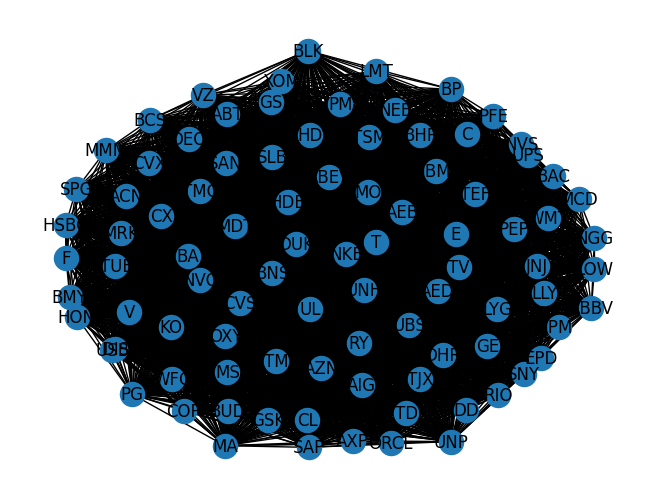

In [39]:
corr_network = nx.Graph()

list_of_comp = [keys for keys in dict_returns]

print(list_of_comp)

num_companies = len(dict_returns.keys())

print(num_companies)

for i1 in range(num_companies - 1):

    for i2 in range(i1 + 1, num_companies):

        stock1 = list_of_comp[i1]

        stock2 = list_of_comp[i2]

        # metric distance
        corr = stocks_corr_coeff(dict_returns[stock1], dict_returns[stock2])

        metric_distance = math.sqrt(2*(1.0 - corr))
        # building the network
        corr_network.add_edge(stock1, stock2, weight = metric_distance)

print("number of nodes:", corr_network.number_of_nodes())
print("number of edges:", corr_network.number_of_edges())

nx.draw(corr_network, with_labels = True)

### Extract the Minimum Spanning Tree with [Prim's algorithm](http://en.wikipedia.org/wiki/Prim%27s_algorithm)

We arbitrarily root the MST in `MMM`.

In [40]:
tree_seed = REF_COMPANY

In [41]:
N_new = []

E_new = []

N_new.append(tree_seed)

while len(N_new) < corr_network.number_of_nodes():

    min_weight = 10_000_000.0

    for n in N_new:
        for n_adj in corr_network.neighbors(n):
            if not n_adj in N_new:
                if corr_network[n][n_adj]['weight'] < min_weight:

                    min_weight = corr_network[n][n_adj]['weight']

                    min_weight_edge = (n,n_adj)

                    n_adj_ext = n_adj

    E_new.append(min_weight_edge)
    N_new.append(n_adj_ext)

# generate the tree from the edge list
tree_graph = nx.Graph()

tree_graph.add_edges_from(E_new)

# setting the color attributes for the network nodes
for n in tree_graph.nodes():
    tree_graph.nodes[n]['color'] = dict_colors[dict_sectors[n]]

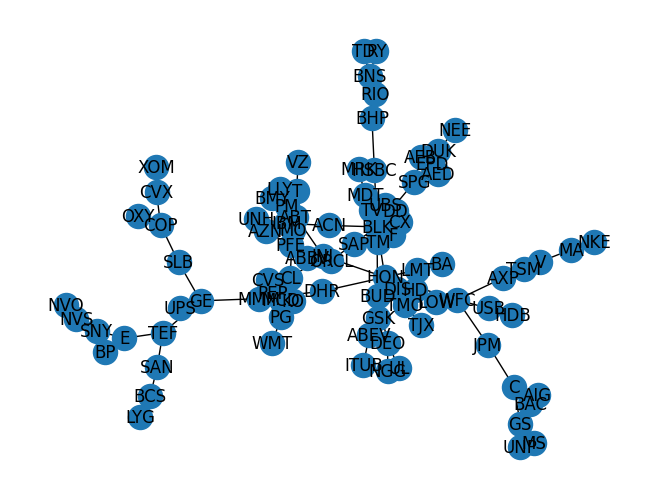

In [42]:
#this is a simpler representation if you have issues with graphviz

nx.draw(tree_graph, with_labels = True)

#### Printing the Financial MST with Graphviz

The cell below spans the full force of `Graphviz`; it might require further module installations such as `pydot` and `neato`.

To avoid issues with the *very tricky* `pygraphviz` installation, the static output for the period studied in the textbook, i.e., the years running up to 31 May 2014.

In the MST representation below we notice the emergence of a few hubs which are easy to interpret. For instance, one is around Honewell (`HON`), which is an industry/defense company, another is Wells Fargo (`WFC`) which is where a branch stems. Finally, BlackRock (`BLK`) is a big hub of financial tickers.

The most intresting insights are *across industries:* for example Johnson & Johnson (`JNJ`) is connected both to pharma, e.g., Pfizer (`PFE`), and to retail, e.g., Colgate (`CL`).

(np.float64(-226.72331500000004),
 np.float64(2730.520315),
 np.float64(-34.92000000000001),
 np.float64(574.9200000000001))

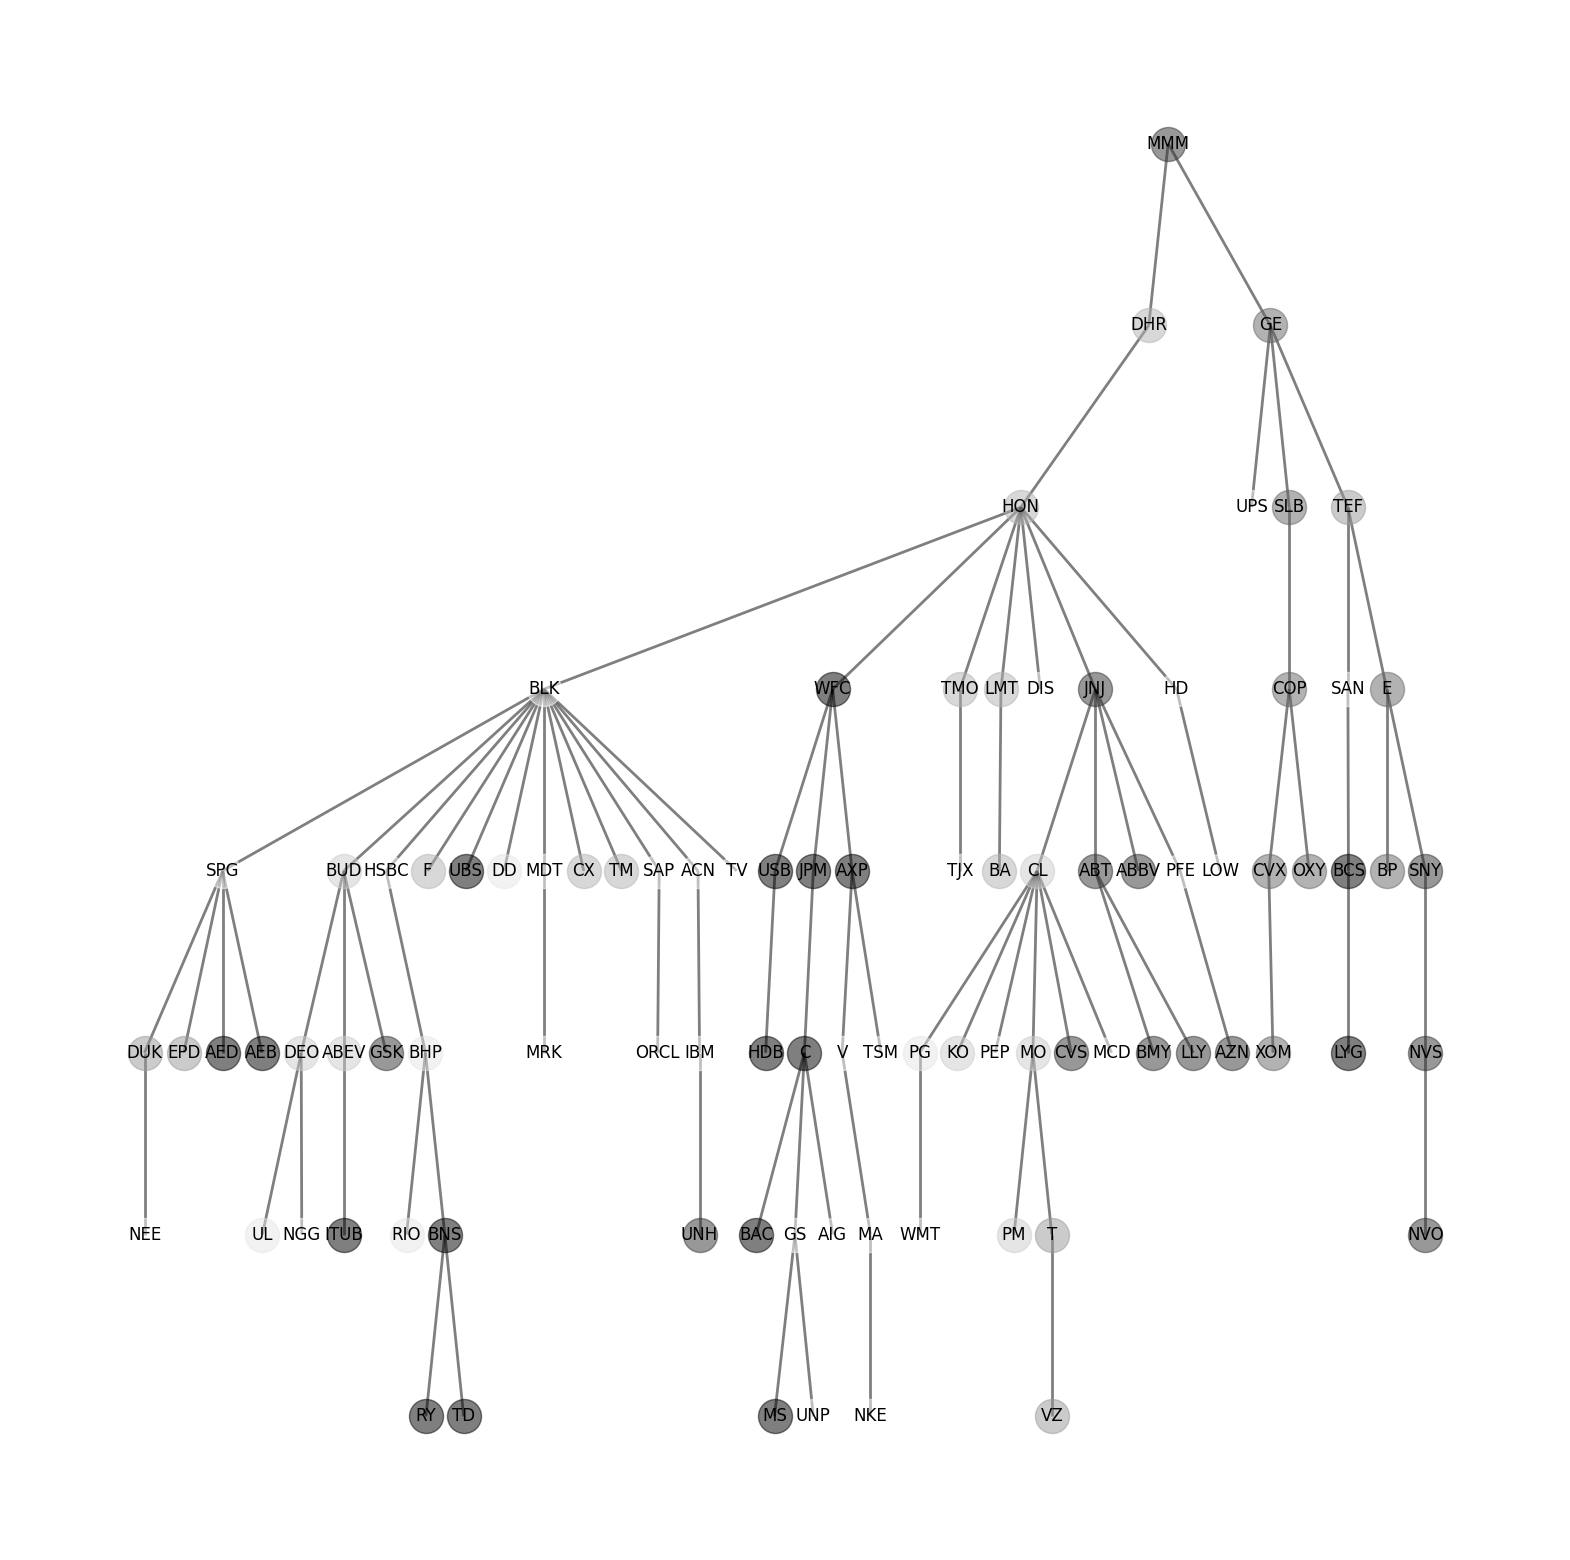

In [43]:
# Pygraphviz solution:
# pos = nx.nx_agraph.graphviz_layout(tree_graph)

# graphviz solution:
pos = graphviz_layout(
    tree_graph,
    prog = 'dot'
    )


plt.figure(figsize = (20, 20))

nx.draw_networkx_edges(
    tree_graph,
    pos,
    width = 2,
    edge_color = 'black',
    alpha = 0.5,
    style = 'solid'
    )

nx.draw_networkx_labels(tree_graph, pos)

for n in tree_graph.nodes():
    nx.draw_networkx_nodes(
        tree_graph, pos, [n], node_size = 600, alpha = 0.5,
        node_color=tree_graph.nodes[n]['color']
        )

plt.axis('off')

#plt.savefig('MST_50B_new.png', dpi=600)


![](./imgs/MSTFinancialNetwork.png)